In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from collections import Counter
import re
import os

This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. Address fields are only provided to the nearest hundred block in order to maintain privacy.

In [27]:
path = os.getenv("get_data")
data = pd.read_csv(filepath_or_buffer=rf"{path}\LA_Crime_Data\Crime_Data_from_2020_to_Present.csv")
df = data.copy()
df.head()

,DR_NO,Date_Reported,Date_occured,Time_occured,Area,Crime_Code,Victim_age,Victim_sex,Victim_descent,Premis,Weapon,Status,LOCATION,LAT,LON
0,190326475,03/01/20 0:00,03/01/20 0:00,2130,Wilshire,VEHICLE - STOLEN,0,M,O,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,02/09/20 0:00,02/08/20 0:00,1800,Central,BURGLARY FROM VEHICLE,47,M,O,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11/11/20 0:00,11/04/20 0:00,1700,Southwest,BIKE - STOLEN,19,X,X,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,1400 W 37TH ST,34.0210,-118.3002
3,200907217,05/10/23 0:00,03/10/20 0:00,2037,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),19,M,O,CLOTHING STORE,NaN,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,Hollywood,THEFT OF IDENTITY,28,M,H,SIDEWALK,NaN,Invest Cont,1900 TRANSIENT,34.0944,-118.3277


### data cleaning and manipulation

#### Renaming of variables

In [31]:
cols_list = df.columns.to_list()
new_cols_list = ["id", "reported", "occurred", "time", "area", "code", "age", "sex", "descent", "premises", "weapon", "status", "location", "latitude", "longitude"]
mapping = {k: v for k, v in zip(cols_list, new_cols_list)}
df.rename(columns=mapping, inplace = True)
df.head(1)

,id,reported,occurred,time,area,code,age,sex,descent,premises,weapon,status,location,latitude,longitude
0,190326475,03/01/20 0:00,03/01/20 0:00,2130,Wilshire,VEHICLE - STOLEN,0,M,O,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506


#### Date transformations

In [34]:
dates_reported = [item[0] for item in map(lambda x: x.split(sep = " "), df["reported"].to_list())]
dates_occurred = [item[0] for item in map(lambda x: x.split(sep = " "), df["occurred"].to_list())]

new_dates_reported = []

for item in dates_reported:
    try:
        obj = datetime.strptime(item, "%m/%d/%y")
        new_dates_reported.append(obj.strftime("%d.%m.%Y"))
    except ValueError:
        try:
            obj = datetime.strptime(item, "%m/%d/%Y")
            new_dates_reported.append(obj.strftime("%d.%m.%Y"))
        except ValueError:
            print(f"invalid_date: {item}")

new_dates_occurred = []

for item in dates_occurred:
    try:
        obj = datetime.strptime(item, "%m/%d/%y")
        new_dates_occurred.append(obj.strftime("%d.%m.%Y"))
    except ValueError:
        try:
            obj = datetime.strptime(item, "%m/%d/%Y")
            new_dates_occurred.append(obj.strftime("%d.%m.%Y"))
        except ValueError:
            print(f"invalid_date: {item}")


In [36]:
df["reported"] = new_dates_reported
df["occurred"] = new_dates_occurred
df.head()

,id,reported,occurred,time,area,code,age,sex,descent,premises,weapon,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,2130,Wilshire,VEHICLE - STOLEN,0,M,O,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,1800,Central,BURGLARY FROM VEHICLE,47,M,O,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11.11.2020,04.11.2020,1700,Southwest,BIKE - STOLEN,19,X,X,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,1400 W 37TH ST,34.0210,-118.3002
3,200907217,10.05.2023,10.03.2020,2037,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),19,M,O,CLOTHING STORE,NaN,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387
4,220614831,18.08.2022,17.08.2020,1200,Hollywood,THEFT OF IDENTITY,28,M,H,SIDEWALK,NaN,Invest Cont,1900 TRANSIENT,34.0944,-118.3277


#### Correction of the time format

In [39]:
new_times = []

for item in df["time"].to_list():
    time = f"{item:04d}"
    new_times.append(f"{time[:2]}:{time[2:]}")

df["time"] = new_times
df.head(2)

,id,reported,occurred,time,area,code,age,sex,descent,premises,weapon,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,21:30,Wilshire,VEHICLE - STOLEN,0,M,O,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,18:00,Central,BURGLARY FROM VEHICLE,47,M,O,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628


#### Adding explanations of descent codes to the dataset.

In [42]:
"""It is assumed that the codes in the descent variable in the dataset are codes used in lineage, ethnic origin, or genetic ancestry research. These haplogroup codes are common among people with origins in those regions."""

ethnic_cultural_codes = {
    'O': 'East Asia, Southeast Asia, Pacific Islands',
    'X': 'Native Americans, isolated populations of Eurasia',
    'H': 'Europe, particularly Western Europe',
    'B': 'Asian and Native American, Pacific Islands, Polynesia',
    'W': 'South Asia, Central Asia, some regions of Europe',
    'A': 'Populations of African descent',
    'K': 'Europe, Middle East, India, Central Asia',
    'C': 'Asia, Australian Aborigines, Native Americans',
    'J': 'Middle East, North Africa, Europe (Jewish communities)',
    'F': 'A wide region of Asia, various populations',
    'I': 'Europe, particularly Northern and Eastern Europe',
    'V': 'Europe and Western Asia, particularly the Iberian Peninsula and Northern Europe',
    'S': 'Pacific Islands, Papua New Guinea, Melanesia',
    'P': 'Asian and Native American populations',
    'Z': 'Northeast Asia, Siberia, East Asia',
    'G': 'Caucasus, Central Asia, Europe',
    'U': 'European, Asian, Middle Eastern populations',
    'D': 'Asian and Native American, Northern Asia',
    'L': 'Africa, particularly Sub-Saharan Africa',
    '-': 'Missing or ambiguous information'
}

In [44]:
df["descent"] = df["descent"].str.strip()

In [46]:

code_list = []
for item in df["descent"].to_list():
    if item in ethnic_cultural_codes.keys():
        code_list.append(ethnic_cultural_codes[item])
    else:
        code_list.append("other")    

df2 = df.copy()
df2.insert(9, column = "descent_info", value = code_list)
df2.head(3)

,id,reported,occurred,time,area,code,age,sex,descent,descent_info,premises,weapon,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,21:30,Wilshire,VEHICLE - STOLEN,0,M,O,"East Asia, Southeast Asia, Pacific Islands",STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,18:00,Central,BURGLARY FROM VEHICLE,47,M,O,"East Asia, Southeast Asia, Pacific Islands",BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11.11.2020,04.11.2020,17:00,Southwest,BIKE - STOLEN,19,X,X,"Native Americans, isolated populations of Eurasia","MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,1400 W 37TH ST,34.0210,-118.3002


#### Generalization of crime codes into 9 main categories.

The generalization process is carried out by matching a set of keywords corresponding to each main category with the code variable present in the dataset. The keywords have been selected from the most frequently occurring words in the code variable.

In [50]:
crime_categories = {
    "Violent Crimes": ['ASSAULT', 'BATTERY', 'HOMICIDE', 'KIDNAPPING', 'ROBBERY', 'LYNCHING', 'TRAFFICKING'],
    "Sexual Crimes": ['SODOMY', 'ORAL COPULATION', 'SEX', 'LEWD', 'RAPE', 'INDECENT', 'PORNOGRAPHY', 'INCEST'],
    "Property Crimes": ['THEFT', 'BURGLARY', 'SHOPLIFTING', 'EMBEZZLEMENT', 'VANDALISM', 'ARSON', 'STOLEN'],
    "Fraud and White-Collar Crimes": ['FRAUD', 'FORGERY', 'COUNTERFEIT', 'BRIBERY', 'CONSPIRACY'],
    "Crimes Against Public Order": ['DISTURBING', 'RIOT', 'TRESPASSING', 'DUMPING', 'DISRUPT'],
    "Crimes Against Family and Children": ['CHILD', 'ABANDONMENT', 'ABUSE', 'NEGLECT', 'ANNOYING'],
    "Weapons and Dangerous Substances Crimes": ['WEAPON', 'BOMB', 'FIREARMS', 'SHOTS', 'POSSESSION'],
    "Crimes Against Justice": ['COURT', 'VIOLATION', 'CONTEMPT', 'FALSE', 'RESISTING'],
    "Other Crimes": []  
}

In [52]:
crime_category_list = []

for item in df2["code"].to_list():
    
    match = False
    for key, keywords in crime_categories.items():
        for keyword in keywords:
            if keyword in item:
                crime_category_list.append(key)
                match = True
                break
        if match:
            break
    if not match:
        crime_category_list.append("Other Crimes")
        
df2.insert(6, column = "code_info", value = crime_category_list)

In [54]:
df2.head(3)

,id,reported,occurred,time,area,code,code_info,age,sex,descent,descent_info,premises,weapon,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,21:30,Wilshire,VEHICLE - STOLEN,Property Crimes,0,M,O,"East Asia, Southeast Asia, Pacific Islands",STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,18:00,Central,BURGLARY FROM VEHICLE,Property Crimes,47,M,O,"East Asia, Southeast Asia, Pacific Islands",BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11.11.2020,04.11.2020,17:00,Southwest,BIKE - STOLEN,Property Crimes,19,X,X,"Native Americans, isolated populations of Eurasia","MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,1400 W 37TH ST,34.0210,-118.3002


#### Generalization of the codes in the "gender" variable

In [57]:
df2["sex"].value_counts(dropna = False, normalize = True)

sex
M      0.404873
F      0.360121
NaN    0.139565
X      0.095326
H      0.000114
-      0.000001
Name: proportion, dtype: float64

In [59]:
df2["sex"] = df["sex"].fillna(value = "other")
df2["sex"] = df2["sex"].replace(to_replace=["X", "H", "-"], value="other")

In [61]:
df2["sex"].value_counts(dropna = False, normalize = True)

sex
M        0.404873
F        0.360121
other    0.235006
Name: proportion, dtype: float64

#### Separation of the "weapon" variable into classes

In [64]:
# Analysis of Repeated Words
words = [item.split() for item in map(str, df["weapon"].to_list())]
word_list = [re.sub(r'[^a-zA-Z]', '', item) for sublist in words for item in sublist if not item == 'nan']
c = Counter(word_list)

# Generalization into 6 main categories.
weapon_category = {
    "Firearms": [
        "HAND GUN",
        "UNKNOWN FIREARM",
        "AIR PISTOL/REVOLVER/RIFLE/BB GUN",
        "SEMI-AUTOMATIC PISTOL",
        "OTHER FIREARM",
        "REVOLVER",
        "SHOTGUN",
        "SEMI-AUTOMATIC RIFLE",
        "ASSAULT WEAPON/UZI/AK47/ETC",
        "HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE",
        "MAC-11 SEMIAUTOMATIC ASSAULT WEAPON",
        "UZI SEMIAUTOMATIC ASSAULT RIFLE",
        "MAC-10 SEMIAUTOMATIC ASSAULT WEAPON",
        "HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE",
        "M1-1 SEMIAUTOMATIC ASSAULT RIFLE"
    ],
    "Cutting Weapons": [
        "KNIFE WITH BLADE 6 INCHES OR LESS",
        "KITCHEN KNIFE",
        "MACHETE",
        "OTHER KNIFE",
        "FOLDING KNIFE",
        "OTHER CUTTING INSTRUMENT",
        "SWITCH BLADE",
        "DIRK/DAGGER",
        "BOWIE KNIFE",
        "RAZOR",
        "RAZOR BLADE",
        "CLEAVER",
        "STRAIGHT RAZOR"
    ],
    "Blunt Objects": [
        "HAMMER",
        "PIPE/METAL PIPE",
        "ROCK/THROWN OBJECT",
        "BRASS KNUCKLES",
        "CLUB/BAT",
        "BLUNT INSTRUMENT",
        "BOARD",
        "STUN GUN",
        "ICE PICK",
        "TIRE IRON"
    ],
    "Chemical and Other Hazardous Materials": [
        "CAUSTIC CHEMICAL/POISON",
        "SCALDING LIQUID",
        "EXPLOSIVE DEVICE",
        "BOMB THREAT"
    ],
    "Simulated Weapons": [
        "SIMULATED GUN",
        "TOY GUN"
    ],
    "Other": [
        "nan"
        "UNKNOWN WEAPON/OTHER WEAPON",
        "UNKNOWN TYPE CUTTING INSTRUMENT",
        "RELIC FIREARM",
        "ANTIQUE FIREARM",
        "MARTIAL ARTS WEAPONS",
        "BOW AND ARROW",
        "SYRINGE",
        "FIXED OBJECT",
        "ROPE/LIGATURE",
        "DOG/ANIMAL (SIC ANIMAL ON)",
        "DEMAND NOTE",
        "LIQUOR/DRUGS",
        "UNK TYPE SEMIAUTOMATIC ASSAULT RIFLE"
    ]
}
weapon_info = []

for item in list(map(str, df2["weapon"].to_list())):
    
    match = False
    for key, keywords in weapon_category.items():
        for keyword in keywords:
            if keyword in item:
                weapon_info.append(key)
                match = True
                break
        if match:
            break
    if not match:
        weapon_info.append("Not Classified")
df3 = df2.copy()
df3.insert(13, column = "weapon_info", value = weapon_info)
df3.head(5)

,id,reported,occurred,time,area,code,code_info,age,sex,descent,descent_info,premises,weapon,weapon_info,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,21:30,Wilshire,VEHICLE - STOLEN,Property Crimes,0,M,O,"East Asia, Southeast Asia, Pacific Islands",STREET,NaN,Not Classified,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,18:00,Central,BURGLARY FROM VEHICLE,Property Crimes,47,M,O,"East Asia, Southeast Asia, Pacific Islands",BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Not Classified,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11.11.2020,04.11.2020,17:00,Southwest,BIKE - STOLEN,Property Crimes,19,other,X,"Native Americans, isolated populations of Eurasia","MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Not Classified,Invest Cont,1400 W 37TH ST,34.0210,-118.3002
3,200907217,10.05.2023,10.03.2020,20:37,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),Property Crimes,19,M,O,"East Asia, Southeast Asia, Pacific Islands",CLOTHING STORE,NaN,Not Classified,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387
4,220614831,18.08.2022,17.08.2020,12:00,Hollywood,THEFT OF IDENTITY,Property Crimes,28,M,H,"Europe, particularly Western Europe",SIDEWALK,NaN,Not Classified,Invest Cont,1900 TRANSIENT,34.0944,-118.3277


#### Transformation of the "status" variable

In [69]:
df3["status"].replace(
    to_replace={"Invest Cont": "Investigation Continued", 
                "Juv Arrest": "Juvenile Arrest",
                "Juv Other": "Juvenile Other",
                "UNK": "Unknown"}, inplace=True)
df3.head(3)

,id,reported,occurred,time,area,code,code_info,age,sex,descent,descent_info,premises,weapon,weapon_info,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,21:30,Wilshire,VEHICLE - STOLEN,Property Crimes,0,M,O,"East Asia, Southeast Asia, Pacific Islands",STREET,NaN,Not Classified,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,18:00,Central,BURGLARY FROM VEHICLE,Property Crimes,47,M,O,"East Asia, Southeast Asia, Pacific Islands",BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Not Classified,Investigation Continued,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11.11.2020,04.11.2020,17:00,Southwest,BIKE - STOLEN,Property Crimes,19,other,X,"Native Americans, isolated populations of Eurasia","MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Not Classified,Investigation Continued,1400 W 37TH ST,34.0210,-118.3002


In [71]:
df3["status"].unique()

array(['Adult Arrest', 'Investigation Continued', 'Adult Other',
       'Juvenile Arrest', 'Juvenile Other', 'Unknown'], dtype=object)

#### Transformation of the "age" variable.

The observations in the 'age' variable that have zero and negative values will be replaced with the mean. Due to outliers, the filling will be done using trimmed mean.


In [75]:
from scipy.stats import trim_mean

In [77]:
df3[df3["age"] <= 0]["age"].value_counts()

age
 0    255459
-1        95
-2        27
-3         5
-4         3
Name: count, dtype: int64

In [93]:
df3["age"] = df3["age"].replace(to_replace=[df3[df3["age"] <= 0]["age"].unique().tolist()], 
                   value = int(trim_mean(df3["age"], proportiontocut= 0.10)),
                    )

In [95]:
df3[df3["age"] <= 0]["age"].value_counts()

Series([], Name: count, dtype: int64)

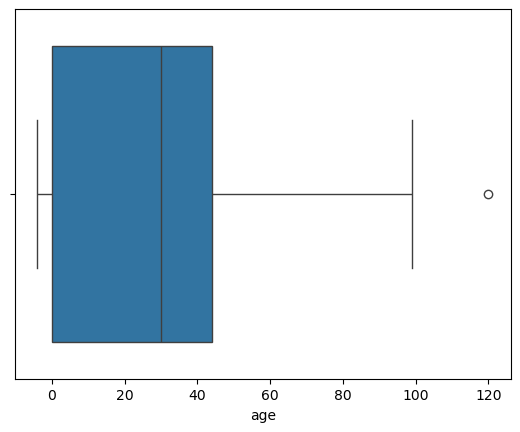

In [97]:
sns.boxplot(data = df["age"], orient = "h");

In [99]:
df3.head(5)

,id,reported,occurred,time,area,code,code_info,age,sex,descent,descent_info,premises,weapon,weapon_info,status,location,latitude,longitude
0,190326475,01.03.2020,01.03.2020,21:30,Wilshire,VEHICLE - STOLEN,Property Crimes,28,M,O,"East Asia, Southeast Asia, Pacific Islands",STREET,NaN,Not Classified,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,09.02.2020,08.02.2020,18:00,Central,BURGLARY FROM VEHICLE,Property Crimes,47,M,O,"East Asia, Southeast Asia, Pacific Islands",BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Not Classified,Investigation Continued,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11.11.2020,04.11.2020,17:00,Southwest,BIKE - STOLEN,Property Crimes,19,other,X,"Native Americans, isolated populations of Eurasia","MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Not Classified,Investigation Continued,1400 W 37TH ST,34.0210,-118.3002
3,200907217,10.05.2023,10.03.2020,20:37,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),Property Crimes,19,M,O,"East Asia, Southeast Asia, Pacific Islands",CLOTHING STORE,NaN,Not Classified,Investigation Continued,14000 RIVERSIDE DR,34.1576,-118.4387
4,220614831,18.08.2022,17.08.2020,12:00,Hollywood,THEFT OF IDENTITY,Property Crimes,28,M,H,"Europe, particularly Western Europe",SIDEWALK,NaN,Not Classified,Investigation Continued,1900 TRANSIENT,34.0944,-118.3277


#### export final data

In [101]:
df3.to_csv(path_or_buf=rf"{path}\LA_Crime_Data\final_data.csv", index=False)

In [ ]:
os.walk()